In [14]:
import pandas as pd
import os
from surprise import Dataset
from surprise import evaluate, print_perf
from surprise import Dataset,Reader
from surprise.model_selection import train_test_split
from surprise.model_selection import cross_validate
from surprise import SVD, SVDpp
from surprise.model_selection import GridSearchCV

In [3]:
df_train = pd.read_excel("C:\\Users\\Sadie\\Desktop\\Major_Research\\data\\movie_sentimental_train.xlsx",encoding='latin-1')
df_test = pd.read_excel("C:\\Users\\Sadie\\Desktop\\Major_Research\\data\\movie_sentimental_test.xlsx",encoding='latin-1')

In [4]:
df_train.count()

file_name       2526
title           2526
user            2526
comment         2526
Final Rating    2526
sentimental     2526
dtype: int64

In [5]:
df_test.count()

file_name       631
title           631
user            631
comment         631
Final Rating    631
sentimental     631
dtype: int64

In [6]:
reader = Reader(rating_scale=(-1, 1))
#sentimental score
train_data_sentimental = Dataset.load_from_df(df_train[['user', 'title', 'sentimental']], reader)
test_data_sentimental = Dataset.load_from_df(df_test[['user', 'title', 'sentimental']], reader)

In [7]:
#Compare SVD and SVDPP

#svd
cross_validate(SVD(), train_data_sentimental, measures=['RMSE', 'MAE'], cv=5, verbose=True) 

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0827  0.0843  0.0857  0.0842  0.0822  0.0838  0.0013  
MAE (testset)     0.0641  0.0655  0.0642  0.0646  0.0636  0.0644  0.0006  
Fit time          0.25    0.22    0.23    0.23    0.23    0.23    0.01    
Test time         0.00    0.02    0.00    0.02    0.00    0.01    0.01    


{'fit_time': (0.2539224624633789,
  0.21598362922668457,
  0.23424124717712402,
  0.2317793369293213,
  0.23178386688232422),
 'test_mae': array([0.06410566, 0.06549534, 0.06424791, 0.06462139, 0.0636238 ]),
 'test_rmse': array([0.0826668 , 0.08425701, 0.08573377, 0.08420495, 0.08222312]),
 'test_time': (0.0,
  0.0156252384185791,
  0.004006624221801758,
  0.015624761581420898,
  0.0)}

In [10]:
#svdpp
cross_validate(SVDpp(), train_data_sentimental, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0783  0.0764  0.0756  0.0740  0.0733  0.0755  0.0018  
MAE (testset)     0.0614  0.0586  0.0575  0.0586  0.0556  0.0584  0.0019  
Fit time          16.23   15.00   14.95   14.38   14.96   15.11   0.61    
Test time         0.18    0.05    0.05    0.07    0.07    0.08    0.05    


{'fit_time': (16.234997510910034,
  14.999342441558838,
  14.954317092895508,
  14.375202417373657,
  14.962997913360596),
 'test_mae': array([0.06143068, 0.05858459, 0.05752399, 0.05864524, 0.05564186]),
 'test_rmse': array([0.0783113 , 0.07640302, 0.07562639, 0.07395455, 0.07325259]),
 'test_time': (0.184403657913208,
  0.05083513259887695,
  0.05339479446411133,
  0.06548881530761719,
  0.06841897964477539)}

In [11]:
#descide to use SVDpp
algo = SVDpp()

In [12]:
#apply to actual rating
train_data_actual = Dataset.load_from_df(df_train[['user', 'title', 'Final Rating']], reader)
test_data_actual = Dataset.load_from_df(df_test[['user', 'title', 'Final Rating']], reader)

In [13]:
cross_validate(algo, train_data_actual, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVDpp on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.3967  0.4362  0.4110  0.3927  0.4010  0.4075  0.0156  
MAE (testset)     0.3163  0.3477  0.3300  0.3176  0.3217  0.3267  0.0115  
Fit time          14.64   15.10   14.31   15.39   14.69   14.83   0.38    
Test time         0.05    0.07    0.06    0.05    0.07    0.06    0.01    


{'fit_time': (14.643361330032349,
  15.104373216629028,
  14.310675144195557,
  15.393134832382202,
  14.686298131942749),
 'test_mae': array([0.31632016, 0.34766596, 0.33002512, 0.31764223, 0.32170798]),
 'test_rmse': array([0.39666081, 0.43623041, 0.41096701, 0.39266363, 0.40099844]),
 'test_time': (0.050513505935668945,
  0.06903553009033203,
  0.06250357627868652,
  0.04988360404968262,
  0.06904387474060059)}

In [15]:
#For Sentimental Score
#Find the best algo by tuning Parameters for SVDpp
param_grid = {'n_epochs': [5, 10], 'lr_all': [0.002, 0.005]}
grid_search = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=5)
grid_search.fit(train_data_sentimental)
best_algo = grid_search.best_estimator['rmse']

In [16]:
#reformat train and test dataset
train_data_sentimental_format = train_data_sentimental.build_full_trainset()
test_data_sentimental_format = train_test_split(test_data_sentimental, test_size=1.0)[1]

In [17]:
#Train and Apply to Test
best_algo.fit(train_data_sentimental_format)
predictions = best_algo.test(test_data_sentimental_format)
predictions

[Prediction(uid='Homer Yen', iid='Review for Sixth Sense, The (1999)', r_ui=0.1361265149944395, est=0.07527180317316784, details={'was_impossible': False}),
 Prediction(uid='Hanson Yoo', iid='Review for Shall We Dansu? (1996)', r_ui=0.2000112309074571, est=0.04096851800637635, details={'was_impossible': False}),
 Prediction(uid='Christian Pyle', iid='Review for Analyze This (1999)', r_ui=0.10090909090909106, est=0.1243703486426857, details={'was_impossible': False}),
 Prediction(uid='Dennis Schwartz', iid='Review for Mecánicas celestes (1993)', r_ui=0.18072222222222223, est=0.07693995652663732, details={'was_impossible': False}),
 Prediction(uid='Michael J. Legeros', iid='Review for Puppet Masters, The (1994)', r_ui=0.0697916666666667, est=0.05484225394786346, details={'was_impossible': False}),
 Prediction(uid='Dennis Schwartz', iid='Review for Pleasantville (1998)', r_ui=0.0983576136235711, est=0.08481684016798408, details={'was_impossible': False}),
 Prediction(uid='Michael J. Leger

In [23]:
# Then compute RMSE
from surprise import accuracy
accuracy.rmse(predictions)

RMSE: 0.0718


0.0718309409841511

In [18]:
df_svd = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details']) 

In [22]:
df_svd.head()
df_svd.count()

uid        631
iid        631
rui        631
est        631
details    631
dtype: int64

<IPython.core.display.Javascript object>


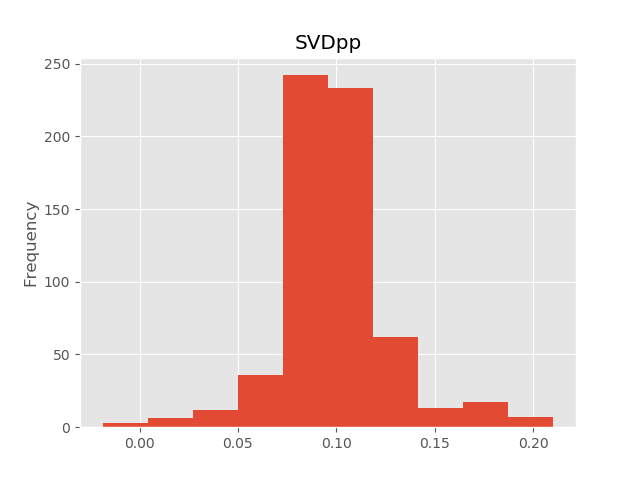

In [20]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib notebook
matplotlib.style.use('ggplot')
plt.subplots(1)
df_svd.est.plot(kind='hist', title='SVDpp')

In [24]:
from collections import defaultdict

from surprise import Dataset
from surprise import SVD
from surprise.model_selection import KFold


def precision_recall_at_k(predictions, k=10, threshold=3.5):
    '''Return precision and recall at k metrics for each user.'''

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 1

        # Recall@K: Proportion of relevant items that are recommended
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 1

    return precisions, recalls

In [25]:
from surprise.model_selection import KFold
precisions, recalls = precision_recall_at_k(predictions, k=5, threshold=0)

In [26]:
avg_prec = sum(prec for prec in precisions.values()) / len(precisions)
avg_rec = sum(rec for rec in recalls.values()) / len(recalls)
F_Measure = 2 / ((1/avg_prec)+(1/avg_rec)) 

In [27]:
F_Measure

0.9142588641859919

In [28]:
#For actual rating

#Find the best algo by tuning Parameters for KNNBaseline
grid_search_actual = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=5)
grid_search_actual.fit(train_data_actual)
best_algo_actual = grid_search.best_estimator['rmse']

In [29]:
#reformat train and test dataset
train_data_actual_format = train_data_actual.build_full_trainset()
test_data_actual_format = train_test_split(test_data_actual, test_size=1.0)[1]

In [30]:
#Train and Apply to Test
best_algo_actual.fit(train_data_actual_format)
predictions_actual = best_algo_actual.test(test_data_actual_format)
predictions_actual

[Prediction(uid='Ron Small', iid='Review for Bring It On (2000)', r_ui=-0.09090909090909083, est=0.03554212503253895, details={'was_impossible': False}),
 Prediction(uid='Michael J. Legeros', iid='Review for Cobb (1994)', r_ui=-0.09090909090909083, est=-0.022072117955979964, details={'was_impossible': False}),
 Prediction(uid='Dennis Schwartz', iid='Review for Equinox (1992)', r_ui=-0.2727272727272727, est=0.059243308490080526, details={'was_impossible': False}),
 Prediction(uid='Dennis Schwartz', iid='Review for Vie de Jésus, La (1997)', r_ui=-0.4545454545454546, est=0.059243308490080526, details={'was_impossible': False}),
 Prediction(uid='Dennis Schwartz', iid='Review for New Rose Hotel (1998)', r_ui=-0.09090909090909083, est=0.059243308490080526, details={'was_impossible': False}),
 Prediction(uid='Michael J. Legeros', iid='Review for Cabin Boy (1994)', r_ui=0.09090909090909083, est=-0.022072117955979964, details={'was_impossible': False}),
 Prediction(uid='Dennis Schwartz', iid='R

In [31]:
precisions_actual, recalls_actual = precision_recall_at_k(predictions_actual, k=5, threshold=0)

In [32]:
avg_prec_actual = sum(prec for prec in precisions_actual.values()) / len(precisions_actual)
avg_rec_actual = sum(rec for rec in recalls_actual.values()) / len(recalls_actual)
F_Measure_actual = 2 / ((1/avg_prec_actual)+(1/avg_rec_actual)) 

In [33]:
F_Measure_actual

0.7064777737157518